# Predict with future weather

In [1]:
from toolbox import *

import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random
import pickle

In [2]:
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [3]:
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFECV, SelectFromModel

from sklearn.model_selection import GridSearchCV

In [4]:
import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")

## Load data

In [5]:
scenario_name = 'scenario_ref'
#ws = load_weather_station_data('./data/weather_station_list.csv')
w = load_weather_data(f'./data/weather_future/{scenario_name}.csv')
w = calc_cumulative_weather(w)

gs = load_groundwater_station_data('./data/groundwater/bergstraße/gw_stations_bergstraße.csv')
g = load_groundwater_data('./data/groundwater/bergstraße/gw.csv')

gs_agg = calc_aggregate_station_data(gs, g)
# setting more years improves model predictions
gs_agg = calc_initial_station_data(gs_agg, g, initial_n_years=5) 
gs_agg = gs_agg.drop('water_temp_mean', axis='columns')

In [6]:
#gs_agg[gs_agg.isna().any(axis=1)]
gs_agg = gs_agg.dropna()
gs_agg.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 212 entries, 0 to 213
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype          
---  ------                      --------------  -----          
 0   station_id                  212 non-null    int64          
 1   x                           212 non-null    float64        
 2   y                           212 non-null    float64        
 3   start_date                  212 non-null    datetime64[ns] 
 4   end_date                    212 non-null    datetime64[ns] 
 5   ground_elev                 212 non-null    float64        
 6   measure_elev                212 non-null    float64        
 7   lifespan                    212 non-null    timedelta64[ns]
 8   geometry                    212 non-null    geometry       
 9   water_level_mean            212 non-null    float64        
 10  water_depth_mean            212 non-null    float64        
 11  ini_years_water_depth_mean  212 non-null  

### Create regional clusters from gw stations

A good number of clusters is 10-12. Re-run if station data is changed.

In [7]:
#explore_clusters(gs_agg[['x', 'y']])

In [8]:
labels, centers = apply_clusters(gs_agg[['x', 'y']], 12, scale=False)

#plot_clusters(gs_agg[['x', 'y']], labels, centers)

# Add clusters to stations
gs_agg['reg_clusters'] = labels
#gs_agg['reg_clusters'] = 0

### Merge data

In [9]:
w['date'] = w.index
w.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2609 entries, 2000-01-03 to 2049-12-27
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   precip_mean               2609 non-null   float64       
 1   moisture_mean             2609 non-null   float64       
 2   tmean_mean                2609 non-null   float64       
 3   precip_std                2609 non-null   float64       
 4   moisture_std              2609 non-null   float64       
 5   tmean_std                 2609 non-null   float64       
 6   precip_mean_prev_2d_sum   2608 non-null   float64       
 7   tmean_mean_prev_2d_mean   2608 non-null   float64       
 8   precip_mean_prev_7d_sum   2603 non-null   float64       
 9   tmean_mean_prev_7d_mean   2603 non-null   float64       
 10  precip_mean_prev_30d_sum  2580 non-null   float64       
 11  tmean_mean_prev_30d_mean  2580 non-null   float64       
 12  pr

In [10]:
df = gs_agg.merge(w, how='cross')

In [11]:
#df.info()

In [12]:
# restrict data to these columns
df = df[['station_id',
        'date',
        #'water_depth',
        'ground_elev',
        'x', 'y',
        'geometry',
        'reg_clusters',
        'ini_years_water_depth_mean',
        'ini_years_water_depth_std',
        'ini_years_water_depth_min',
        'ini_years_water_depth_max',
        'precip_mean',
        'tmean_mean',
        'moisture_mean',
        'precip_mean_prev_2d_sum',
        'precip_mean_prev_7d_sum',
        'precip_mean_prev_30d_sum',
        'precip_mean_prev_90d_sum',
        'precip_mean_prev_1y_sum',
        'precip_mean_prev_3y_sum',
        'tmean_mean_prev_2d_mean',
        'tmean_mean_prev_7d_mean',
        'tmean_mean_prev_30d_mean',
        'tmean_mean_prev_90d_mean',
        'tmean_mean_prev_1y_mean',
        'tmean_mean_prev_3y_mean'
       ]]
#df.info()

In [13]:
#df.describe()

### Prepare data

In [14]:
#df[df.isna().any(axis=1)]

In [15]:
df = df.dropna()
#df

In [16]:
reserve_cols_as_info = ['station_id', 'date', 'geometry']
    
info = df[reserve_cols_as_info].copy()

X = df.copy().drop(reserve_cols_as_info, axis=1)

## Unpickle model

In [17]:
# load model
if True:
    name = 'HGBoost'
    
    with open(f'./models/{name}.pkl', 'rb') as file:
        model = pickle.load(file)
    
    model#.best_params_

## Predict groundwater levels

In [18]:
y_pred = pd.DataFrame(model.predict(X), columns=['pred_water_depth'])
y_pred.index = info.index
#y_pred.head()

In [19]:
#X.head()

In [20]:
#info.head()

In [21]:
pred = pd.concat([info, X, y_pred], axis='columns')
pred.head()

,station_id,date,geometry,ground_elev,x,y,reg_clusters,ini_years_water_depth_mean,ini_years_water_depth_std,ini_years_water_depth_min,...,precip_mean_prev_90d_sum,precip_mean_prev_1y_sum,precip_mean_prev_3y_sum,tmean_mean_prev_2d_mean,tmean_mean_prev_7d_mean,tmean_mean_prev_30d_mean,tmean_mean_prev_90d_mean,tmean_mean_prev_1y_mean,tmean_mean_prev_3y_mean,pred_water_depth
1094,12890,2020-12-21,POINT (8.42892 49.70283),87.44,458821.0,5505747.0,0,2.11613,0.590349,0.46,...,189.026446,702.756536,2108.873067,2.181931,3.661694,12.721502,11.099057,10.087639,10.086258,1.647889
1095,12890,2020-12-28,POINT (8.42892 49.70283),87.44,458821.0,5505747.0,0,2.11613,0.590349,0.46,...,188.438726,700.604033,2106.678185,2.269554,3.097172,12.242601,11.033211,10.091079,10.086698,1.647889
1096,12890,2021-01-04,POINT (8.42892 49.70283),87.44,458821.0,5505747.0,0,2.11613,0.590349,0.46,...,187.984840,702.423306,2106.137710,1.200306,2.298393,11.700601,10.931142,10.088957,10.085491,1.647889
1097,12890,2021-01-11,POINT (8.42892 49.70283),87.44,458821.0,5505747.0,0,2.11613,0.590349,0.46,...,188.757380,704.277353,2108.029799,0.956046,1.952705,11.188859,10.828105,10.092039,10.086746,1.694863
1098,12890,2021-01-18,POINT (8.42892 49.70283),87.44,458821.0,5505747.0,0,2.11613,0.590349,0.46,...,190.620455,706.553741,2109.714765,1.020514,1.679980,10.625766,10.707524,10.089035,10.086147,1.694863


In [22]:
if False:
    pred.to_feather(f'./data/predictions/{scenario_name}.feather')

## Analyse prediction

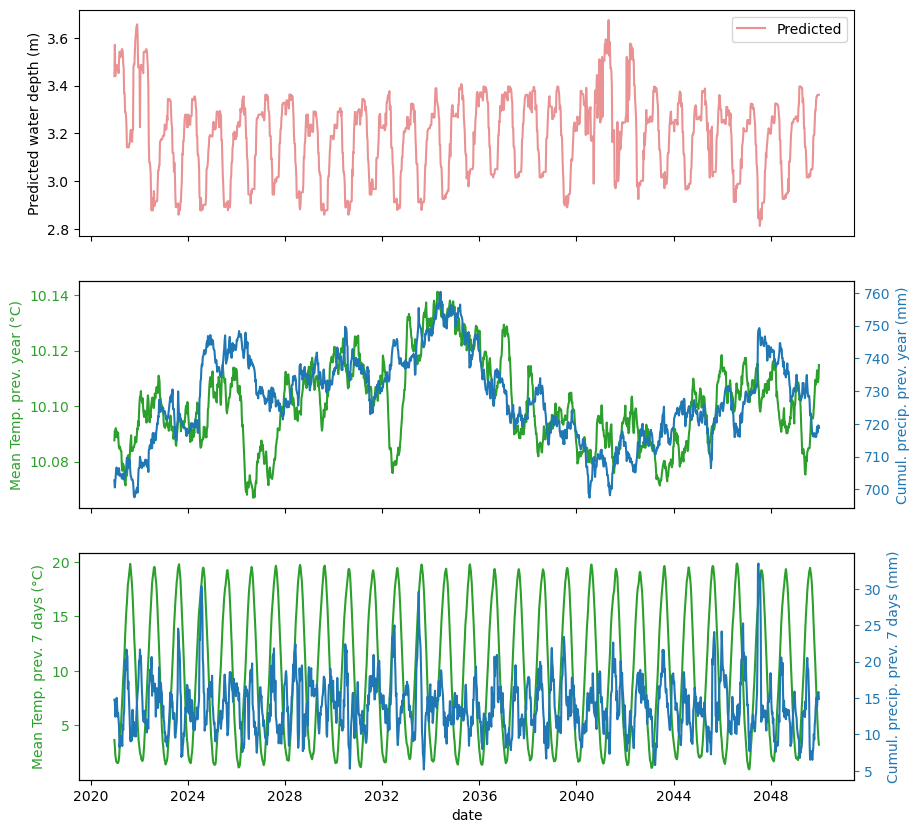

In [24]:
data = pred.loc[pred.station_id == pred.station_id.unique()[2]]

plot_predicted_data(data,
                  #pd.to_datetime('2035-01-01'), pd.to_datetime('2045-01-10'),
                  #pd.to_datetime('2010-01-01'), pd.to_datetime('2020-01-10')
                  #save=True
                 )

#plt.savefig('./figs/test.png', bbox_inches='tight')